# 2.2 간단한 Retrieval 에이전트 (feat. PDF 전처리 꿀팁)

- RAG 에이전트를 만들어봅니다
- [zerox](https://zerox.ai/)를 통해 PDF 파일을 전처리하는 방법을 알아봅니다


## 환경설정

- RAG 파이프라인을 위해 필요한 패키지들을 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [1]:
%pip install -qU pypdf langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


- `PyPDFLoader`를 사용해 전처리된 데이터를 확인합니다

In [2]:
from langchain_community.document_loaders import PyPDFLoader

pdf_file_path = './documents/income_tax.pdf'
loader = PyPDFLoader(pdf_file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [3]:
pages[35]

Document(metadata={'producer': 'iText 2.1.7 by 1T3XT', 'creator': 'PyPDF', 'creationdate': '2025-01-10T10:55:01+09:00', 'moddate': '2025-01-10T10:55:01+09:00', 'source': './documents/income_tax.pdf', 'total_pages': 133, 'page': 35, 'page_label': '36'}, page_content='법제처                                                            36                                                       국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 “퇴직소득 산출세액”이라 한다\n)으로 한다.<개정 2013. 1. 1., 2014. 12. 23.>\n1. 해당 과세기간의 퇴직소득과세표준에 제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n \n           제2관 세액공제 <개정 2009. 12. 31.>\n \n제56조(배당세액공제) ① 거주자의 종합소득금액에 제17조제3항 각 호 외의 부분 단서가 적용되는 배당소득금액이 합\n산되어 있는 경우에는 같은 항 각 호 외의 부분 단서에 따라 해당 과세기간의 총수입금액에 더한 금액에 해당하는\n금액을 종합소득 산출세액에서 공제한다. <개정 2009. 12. 31.>\n② 제1항에 따른 공제를 “배당세액공제”라 한다.<개정 2009. 12. 31.>\n③ 삭제<2003. 12. 30.>\n④ 제1항을 적용할 때 배당세액공제의 대상이 되는 배당소득금액은 제14조제2항의 종합소득과세표준에 포함된 배\n당소득금액으로서 이자소득등의 종합과세기준

- 데이터 전처리를 위한 [py-zerox](https://www.piwheels.org/project/py-zerox/) 패키지를 설치합니다

In [4]:
%pip install -q py-zerox

Note: you may need to restart the kernel to use updated packages.


In [5]:
from dotenv import load_dotenv

load_dotenv()

True

- 노트북에서 `asyncio`를 사용하기 위해 `nest_asyncio`를 설치합니다

In [6]:
%pip install -q nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [7]:
import nest_asyncio
nest_asyncio.apply()

- `py-zerox`를 통해 pdf파일을 전처리합니다
- 강의에서는 `OpenAI`를 사용하지만, 아래 예제는 `AzureOpenAI`를 사용합니다

In [18]:
from pyzerox import zerox
import os
import json
import asyncio
from langchain_openai import ChatOpenAI
from litellm import completion

### 모델 설정 (Vision 모델만 사용) 참고: https://docs.litellm.ai/docs/providers ###
model = "gpt-4o-mini"  # 비전 기능을 사용하는 모델 이름

## 일부 모델에 필요할 수 있는 추가 모델 kwargs의 자리 표시자
kwargs = {}

## Vision 모델에 사용할 시스템 프롬프트
custom_system_prompt = None

# 메인 비동기 진입점을 정의합니다
async def main():
    file_path = "./documents/income_tax.pdf" ## 로컬 파일 경로 및 파일 URL 지원

    ## 일부 페이지 또는 전체 페이지를 처리
    select_pages = None ## 전체는 None, 특정 페이지는 int 또는 list(int) 페이지 번호 (1부터 시작)

    output_dir = "./documents" ## 통합된 마크다운 파일을 저장할 디렉토리
    result = await zerox(
        file_path=file_path,
        model=model,
        output_dir=output_dir,
        custom_system_prompt=custom_system_prompt,
        select_pages=select_pages,
        **kwargs,
    )
    return result


# 메인 함수를 실행합니다:
result = asyncio.run(main())

# 마크다운 결과를 출력합니다
print(result)

KeyboardInterrupt: 

- zerox를 활용한 전처리 후 생성된 마크다운 파일을 LangGraph에서 활용하기 위해 [unstructured](https://unstructured.io/) 패키지를 설치합니다
- `UnstructuredMarkdownLoader`를 사용해 전처리된 데이터를 확인합니다
    - `loader`활용 시 테이블 구조가 사라지는 것을 확인할 수 있습니다

In [1]:
%pip install -q "unstructured[md]" nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

In [3]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_path = "./documents/income_tax.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(text_splitter)

In [6]:
document_list[40]

Document(metadata={'source': './documents/income_tax.md'}, page_content='제2절 세액의 계산 <개정 2009. 12. 31.> 제1관 세율 <개정 2009. 12. 31.>\n\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n종합소득 ┌───────────────┐ │ 과세표준의 6개 구간 │ ├───────────────┤ │ 1,400만원 이하 │ 84만원 + (1,400만원을 초과하는 금액의 15%) │ │ 1,400만원 초과 │ 84만원 + (5,000만원을 초과하는 금액의 24%) │ │ 8,800만원 이하 │ 624만원 + (5,000만원을 초과하는 금액의 24%) │ │ 8,800만원 초과 │ 1,536만원 + (8,800만원을 초과하는 금액의 35%) │ │ 1.5억원 초과 │ 4,046만원 + (1,500만원을 초과하는 금액의 38%) │ │ 3억원 초과 │ 6,460만원 + (3억원을 초과하는 금액의 40%) │ │ 5억원 초과 │ 14,760만원 + (5억원을 초과하는 금액의 42%) │ │ 10억원 초과 │ 38,406만원 + (10억원을 초과하는 금액의 45%) │ └───────────────┘\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 ‘퇴직소득 산출세액’이라 한다)으로 한다. <개정 2013. 1. 1., 2014. 12. 23.> 1. 해당 과세기간의 퇴직소득과세표준 제1항의 세율을 적용하여 계산한 금액 2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액 3. 삭제<2014. 12. 23.> [전문개정 2009. 12. 31.]\n\n제2관 세액공제 

- 마크다운 테이블을 활용하기 위해 `.md` -> `.txt`로 변환합니다

In [7]:
%pip install -q markdown html2text beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [8]:
import markdown
from bs4 import BeautifulSoup

text_path = './documents/income_tax.txt'

# 마크다운 파일을 읽어옵니다
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


- `TextLoader`를 사용해 전처리된 데이터를 확인합니다

In [9]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [17]:
document_list[42]

Document(metadata={'source': './documents/income_tax.txt'}, page_content='환산급여에 따라 정한 다음의 금액\n\n| 환산금여        | 공 제 악                |\n|----------------|------------------------|\n| 8백만원 이하     | 환산금여의 10퍼센트       |\n| 8백만원 초과 7백만원 이하 | 8백만원×(8백만원 초과분의 60퍼센트)  |\n| 7백만원 초과 1억원 이하 | 4천520만원×(7백만원 초과분의 55퍼센트) |\n| 1억원 초과 3억원 이하 | 6천170만원×(1억원 초과분의 45퍼센트)  |\n| 3억원 초과      | 1억5천170만원+(3억원 초과분의 35퍼센트) |\n② 해당 과세기간의 퇴직소득금액이 제1항제1호에 따른 공제금액에 미달하는 경우에는 그 퇴직소득금액을 공제액으로 한다. <개정 2014. 12. 23.>\n③ 제1항과 제2항에 따른 공제를 \'퇴직소득공제\'라 한다.\n④ 퇴직소득금액 계산 방법에 필요한 사항은 대통령령으로 정한다. <개정 2013. 1. 1.>\n[전문개정 2009. 12. 31.]\n제49조 삭제 <2006. 12. 30.>\n제관 종합소득공제 <개정 2009. 12. 31.>\n제50조(가난공제)\n가. 종합소득이 있는 거주자(자연인인 해외단체)에 대해서는 다음 각 호의 어느 하나에 해당하는 사람의 수에 1명당 연 150만 원을 곱하여 계산한 금액을 그 거주자의 해당 과세기간의 종합소득금액에서 공제한다. <개정 2015. 12. 15.>\n\n거주자\n\n거주자가 배우자로서 해당 과세기간의 소득금액이 없거나 해당 과세기간의 소득금액 합계가 100만원 이하인 사람(종합소득이 500만원 이하인 근로소득 있는 배우자를 포함한다)\n\n\n거주자와 배우자를 포함한다. 이하 이 호에서 갈과 생계를 같이 하는 다음 각 목의 어느 하나에 해당하는 부양가족(제15조제1항제3호와같이 장애인에 

- 전처리된 데이터를 벡터화하기 위해 [Chroma](https://docs.trychroma.com/getting-started)를 활용합니다
- LangChain과의 호환을 위해 [langchain-chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)를 설치합니다

In [18]:
%pip install -q langchain-chroma

Note: you may need to restart the kernel to use updated packages.


In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [20]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)

In [21]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [22]:
query = '연봉 5천만원 직장인의 소득세는?'

In [23]:
retriever.invoke(query)

[Document(id='95d561f3-2f05-44c6-b21c-95ec7c509a43', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
 Document(id='31c16de5-037c-4ddb-86f9-3a3797bc2198', metadata={'source': './documents/income_tax.txt'}, page_content='이자소득에 대해서는 다음과 같이 규정하는 세율\n가. 삭제<2017. 12. 19.>\n나. 비영업대금의 이

- `state`를 선언하고 에이전트를 생성합니다
- 2.1강에서 진행한 것과 다르게 `messages` 커스텀 변수들을 선언합니다
    - `query`는 사용자의 질문을 저장하는 용도로 사용합니다
    - `context`는 벡터 스토어에서 추출한 데이터를 저장하는 용도로 사용합니다
    - `answer`는 최종 응답을 저장하는 용도로 사용합니다

In [24]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [2]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

- `retrieve` 노드는 사용자의 질문을 받아 벡터 스토어에서 추출한 데이터를 반환합니다

In [3]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

- `LangChain`의 `hub`를 통해 미리 정의된 RAG 프롬프트를 활용합니다
    - `hub`에는 이미 검증된 프롬프트들이 많기 때문에 프로젝트 진행 시 좋은 시작점이 됩니다
    - `hub`에서 프롬프트를 찾아보고, 동작을 확인한 후 커스텀 하는 것을 권장합니다

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model='gpt-4o')


/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
def generate(state: AgentState) -> AgentState:
    """
    사용자의 질문과 검색된 문서를 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답이 추가된 state를 반환합니다.
    """
    context = state['context']  # state에서 검색된 문서를 추출합니다.
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    rag_chain = prompt | llm  # RAG 프롬프트와 LLM을 연결하여 체인을 만듭니다.
    response = rag_chain.invoke({'question': query, 'context': context})  # 질문과 문맥을 사용하여 응답을 생성합니다.
    return {'answer': response}  # 생성된 응답을 포함한 state를 반환합니다.

- `node`를 추가하고 `edge`로 연결합니다

In [6]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [7]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

In [8]:
graph = graph_builder.compile()

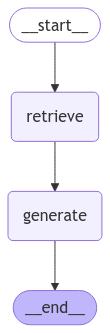

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- 병렬처리나 `conditional_edge`가 없는 경우 `add_sequence()`를 통해 순차적으로 동작하는 그래프를 생성할 수 있습니다

In [10]:
sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

In [11]:
sequence_graph_builder.add_edge(START, 'retrieve')
sequence_graph_builder.add_edge('generate', END)

In [12]:
sequence_graph = sequence_graph_builder.compile()

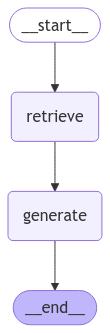

In [13]:
display(Image(sequence_graph.get_graph().draw_mermaid_png()))

In [22]:
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(metadata={'source': './documents/income_tax.txt'}, page_content='이자소득에 대해서는 다음과 같이 규정하는 세율\n가. 삭제<2017. 12. 19.>\n나. 비영업대금의 이익에 대해서는 100분의 25. 단, ‘온라인투자연계금융업 및 이용자 보호